In [41]:
import xarray as xr
import numpy as np
import datetime
from scipy.ndimage import gaussian_filter

from meteoSI import mod_ad

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from PlottingUtility import load_cbar_style, load_xy_style
from Utils import find_bases_tops
import Colormaps

_FIG_SIZE = (14, 4.7)

font_settings = {
    'range_interval': [0, 6000],
    'fig_size': [15, 10],
    'rg_converter': True,
    'font_size': 15,
    'font_weight': 'normal',
    'zlabel': '',
}


# trained on >100 epochs of 60/600 (20181127-20190927)
voodoo_nc = '20190801-20190801-20201017-174440__20201017-174440_weights_compressed.h5.nc'
#voodoo_nc = '20190313-20190313-20201017-174440__20201017-174440_weights_compressed.h5.nc'
case = voodoo_nc[:8]
YYYY, MM, DD = int(case[:4]), int(case[4:6]), int(case[6:8]) 


In [42]:
# open the dataset using xarray
voodoo_xr = xr.open_mfdataset(f'data/{voodoo_nc}')

# convert to datetime
dt_list = [datetime.datetime.fromtimestamp(ts) for ts in voodoo_xr.ts.values]
print(voodoo_xr)


# look at important classes "ice", "ice and supercooled droplets", "cloud droplets only", and "drizzle/rain"
P_mixed = voodoo_xr['voodoo_classification_probabilities'][:, :, 5].copy()
P_droplets = voodoo_xr['voodoo_classification_probabilities'][:, :, 1].copy()

# all classes containing cloud droplets
P_allCD = P_droplets.copy()
P_allCD.values = P_mixed.values + P_droplets.values


<xarray.Dataset>
Dimensions:                              (cl: 9, rg: 292, ts: 1081)
Coordinates:
  * ts                                   (ts) float64 1.565e+09 ... 1.565e+09
  * rg                                   (rg) float64 119.2 149.1 ... 1.196e+04
  * cl                                   (cl) int64 0 1 2 3 4 5 6 7 8
    temperature                          (ts, rg) float64 dask.array<shape=(1081, 292), chunksize=(1081, 292)>
    pressure                             (ts, rg) float64 dask.array<shape=(1081, 292), chunksize=(1081, 292)>
    target_classification                (ts, rg) int32 dask.array<shape=(1081, 292), chunksize=(1081, 292)>
    mask                                 (ts, rg) bool dask.array<shape=(1081, 292), chunksize=(1081, 292)>
    lwp                                  (ts) float32 dask.array<shape=(1081,), chunksize=(1081,)>
Data variables:
    voodoo_classification_probabilities  (ts, rg, cl) float32 dask.array<shape=(1081, 292, 9), chunksize=(1081, 292, 9)>

# Smooth the predictions using a Gaussian filter


In [43]:

P_allCD.values = gaussian_filter(P_allCD.values, sigma=1.0)


# calculate adiabatic liquid water path from temperature and pressure profiles
calculate  liquid water path for cloud droplet containing pixel, if $P(\hat{y}=1 \wedge \hat{y}=5) > 0.7$, for a prediction $\hat{y} = \mathrm{voodoo}(\mathrm{X})$

In [44]:
                            
def calc_adLWP(liquid_mask, temperature, pressure, rg):

    bt_lists, bt_mask = find_bases_tops(liquid_mask, rg)
    adLWP = np.zeros(liquid_mask.shape[0])

    for iT in range(liquid_mask.shape[0]):
        
        n_cloud_layers = len(bt_lists[iT]['idx_cb'])
        if n_cloud_layers < 1: continue

        lwc = 0
        for iL in range(n_cloud_layers):
            tmp_idx = np.arange(bt_lists[iT]['idx_cb'][iL], bt_lists[iT]['idx_ct'][iL], dtype=np.int)
            if tmp_idx.size > 1:  # exclude single range gate clouds
                # calculates adiabatic lwc
                lwc += np.sum(mod_ad(temperature[iT, tmp_idx], pressure[iT, tmp_idx], rg[tmp_idx]))   # kg/m3

        adLWP[iT] = np.sum(lwc * 1000)    # kg/m3 --> g/m3

    return adLWP


In [104]:
liquid_probability_threshold = 0.7

liquid_mask_voodoo = P_allCD.values > liquid_probability_threshold
liquid_mask_cloudnet = (voodoo_xr.target_classification.values == 1) + (voodoo_xr.target_classification.values == 5)

adiabLWP_voodoo = calc_adLWP(liquid_mask_voodoo, voodoo_xr.temperature.values, voodoo_xr.pressure.values, voodoo_xr.rg.values)
adiabLWP_cloudnet = calc_adLWP(liquid_mask_cloudnet, voodoo_xr.temperature.values, voodoo_xr.pressure.values, voodoo_xr.rg.values)


/Users/willi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


# plot adiabatic lwp / MWR lwp and probability for cloud droplets


smooth 20 time steps or 600 [sec]


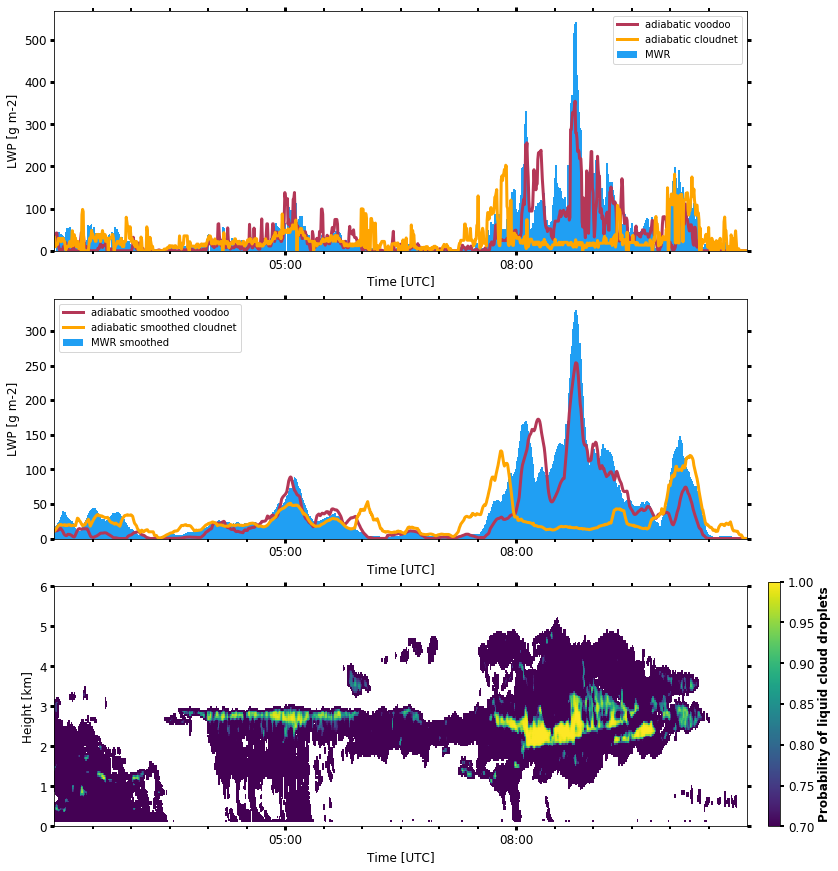

In [105]:
idk_factor = 50
box_pts = 20
lw = 3.0
print(f'smooth {box_pts} time steps or {box_pts*30} [sec]')

box = np.ones(box_pts) / box_pts
X_smoothed = np.convolve(voodoo_xr.lwp.values, box, mode='same')
Yv_smoothed = np.convolve(adiabLWP_voodoo, box, mode='same')
Yc_smoothed = np.convolve(adiabLWP_cloudnet, box, mode='same')

fig, ax = plt.subplots(nrows=3, figsize=(15.05, 15))
line = ax[0].plot(dt_list, adiabLWP_voodoo*idk_factor, color=Colormaps.cloudnet_colors[10], linewidth=lw, label='adiabatic voodoo')
line = ax[0].plot(dt_list, adiabLWP_cloudnet*idk_factor, color=Colormaps.cloudnet_colors[6], linewidth=lw, label='adiabatic cloudnet')
line = ax[0].bar(dt_list, voodoo_xr.lwp.values, width=0.001, color=Colormaps.cloudnet_colors[2], label='MWR')
load_xy_style(ax[0], ylabel='LWP [g m-2]')
ax[0].set_xlim([dt_list[0], dt_list[-1]])
ax[0].legend()

line = ax[1].plot(dt_list, Yv_smoothed*idk_factor, color=Colormaps.cloudnet_colors[10], linewidth=lw, label='adiabatic smoothed voodoo')
line = ax[1].plot(dt_list, Yc_smoothed*idk_factor, color=Colormaps.cloudnet_colors[6], linewidth=lw, label='adiabatic smoothed cloudnet')
line = ax[1].bar(dt_list, X_smoothed, color=Colormaps.cloudnet_colors[2], width=0.001, label='MWR smoothed')
load_xy_style(ax[1], ylabel='LWP [g m-2]')
ax[1].set_xlim([dt_list[0], dt_list[-1]])
ax[1].legend()

P_allCD.values = np.ma.masked_where(voodoo_xr.mask, P_allCD)
pmesh = ax[2].pcolormesh(dt_list, voodoo_xr.rg.values/1000., P_allCD.values.T, cmap='viridis', vmin=liquid_probability_threshold, vmax=1)
cbar = fig.colorbar(pmesh, ax=ax, pad=0.025, shrink=0.3, anchor=(0.0, 0.0))
ax[2].set_ylim([0, 6])
load_xy_style(ax[2], ylabel='Height [km]')
load_cbar_style(cbar, cbar_label='Probability of liquid cloud droplets')
#fig.savefig(f'plots/{case}-liquid-cloud-doplet-probability.png', dpi=450)


In [106]:

corr_raw_voodoo = np.ma.corrcoef(np.ma.masked_less_equal(voodoo_xr.lwp.values, 0.0), np.ma.masked_less_equal(adiabLWP_voodoo, 0.0))[0, 1]
corr_raw_cloudnet = np.ma.corrcoef(np.ma.masked_less_equal(voodoo_xr.lwp.values, 0.0), np.ma.masked_less_equal(adiabLWP_cloudnet, 0.0))[0, 1]
corr_smoothed_voodoo = np.ma.corrcoef(np.ma.masked_less_equal(X_smoothed, 0.0), np.ma.masked_less_equal(Yv_smoothed, 0.0))[0, 1]
corr_smoothed_cloudnet = np.ma.corrcoef(np.ma.masked_less_equal(X_smoothed, 0.0), np.ma.masked_less_equal(Yc_smoothed, 0.0))[0, 1]

print(f'        correlation raw prediction VOODOO = {corr_raw_voodoo:.2f}')
print(f'                     correlation CLOUDNET = {corr_raw_cloudnet:.2f}')
print(f'  correlation smoothed predicitons VOODOO = {corr_smoothed_voodoo:.2f}')
print(f'            correlation smoothed CLOUDNET = {corr_smoothed_cloudnet:.2f}')
print(f'          maximum liquid water path value = {corr_raw_voodoo.max():.2f} [g m-2]') 


        correlation raw prediction VOODOO = 0.80
                     correlation CLOUDNET = 0.10
  correlation smoothed predicitons VOODOO = 0.90
            correlation smoothed CLOUDNET = 0.23
          maximum liquid water path value = 0.80 [g m-2]
